# Zero-shot learning

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.0 MB/s eta 0

In [2]:
# Import libraries
import os
import numpy as np

import gzip
import _pickle as cPickle

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.preprocessing import normalize
from torch_snippets import *

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Thu Apr 11 01:19:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Clone the repository for Zero-Shot Learning
!git clone https://github.com/sizhky/zero-shot-learning/
%cd zero-shot-learning/src

Cloning into 'zero-shot-learning'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 102 (delta 20), reused 19 (delta 19), pack-reused 79
Receiving objects: 100% (102/102), 134.47 MiB | 22.45 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/zero-shot-learning/src


In [5]:
# Retrieve the list of classes
with open('train_classes.txt', 'r') as infile:
    train_classes = [str.strip(line) for line in infile]

In [6]:
# Define the paths to word embeddings and the features data
word2vec_path = "../data/class_vectors.npy"
data_path = "../data/zeroshot_data.pkl"

In [7]:
# Load the features vectors
with gzip.GzipFile(data_path, 'rb') as infile:
    data = cPickle.load(infile)

In [10]:
# Define the training and zero-shot data
training_data = [instance for instance in data if instance[0] in train_classes]
zero_shot_data = [instance for instance in data if instance[0] not in train_classes]

# Shuffle the training data
np.random.shuffle(training_data)

In [11]:
# Split the training data into training and validation sets (300 samples per class for training)
train_data, valid_data = [], []
for class_label in train_classes:
    ctr = 0
    for instance in training_data:
        if instance[0] == class_label:
            if ctr < 300: # 300 samples per class
                train_data.append(instance)
                ctr += 1
            else:
                valid_data.append(instance)

In [12]:
# Shuffle the training and validation data
np.random.shuffle(train_data)
np.random.shuffle(valid_data)

# Obtain the vectors corresponding to the class labels
vectors = dict(np.load(word2vec_path, allow_pickle=True))

In [13]:
# Gather the image and word embeddings for the training and validation data
train_data = [(feat, vectors[clss]) for (clss, feat) in train_data]
valid_data = [(feat, vectors[clss]) for (clss, feat) in valid_data]

In [14]:
# Fetch the class labels for the training, validation, and zero-shot data
train_clss = [clss for clss, _ in train_data]
valid_clss = [clss for clss, _ in valid_data]
zero_shot_clss = [clss for clss, _ in zero_shot_data]

In [15]:
# Define input and output for the training, validation, and zero-shot data, then normalize the input data
x_train, y_train = zip(*train_data)
x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
x_train = normalize(x_train, norm='l2')

x_valid, y_valid = zip(*valid_data)
x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
x_valid = normalize(x_valid, norm='l2')

y_zsl, x_zsl = zip(*zero_shot_data)
x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
x_zsl = normalize(x_zsl, norm='l2')

In [16]:
# Create train and validation datasets
train_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_train, y_train]])
val_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_valid, y_valid]])

# Create a function to retrieve the dataloaders
def load_data(batch_size = 32):
    trn_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return trn_dl, val_dl

In [17]:
# Create a function to load the model
def load_model():
    return nn.Sequential(
        nn.Linear(4096, 1024), nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024), nn.Dropout(0.8),
        nn.Linear(1024, 512), nn.ReLU(inplace=True),
        nn.BatchNorm1d(512), nn.Dropout(0.8),
        nn.Linear(512, 256), nn.ReLU(inplace=True),
        nn.BatchNorm1d(256), nn.Dropout(0.8),
        nn.Linear(256, 300)
    )

In [18]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images, labels = data
    preds = model(images)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, labels = data
    preds = model(images)
    loss = criterion(preds, labels)
    return loss.item()

EPOCH: 10.000  val_loss: 0.015  train_loss: 0.019  (8.73s - 43.66s remaining)
EPOCH: 20.000  val_loss: 0.012  train_loss: 0.014  (16.30s - 32.61s remaining)
EPOCH: 30.000  val_loss: 0.011  train_loss: 0.013  (24.02s - 24.02s remaining)
EPOCH: 40.000  val_loss: 0.010  train_loss: 0.012  (31.84s - 15.92s remaining)
EPOCH: 50.000  val_loss: 0.010  train_loss: 0.011  (39.32s - 7.86s remaining)
EPOCH: 60.000  val_loss: 0.010  train_loss: 0.011  (47.19s - 0.00s remaining)


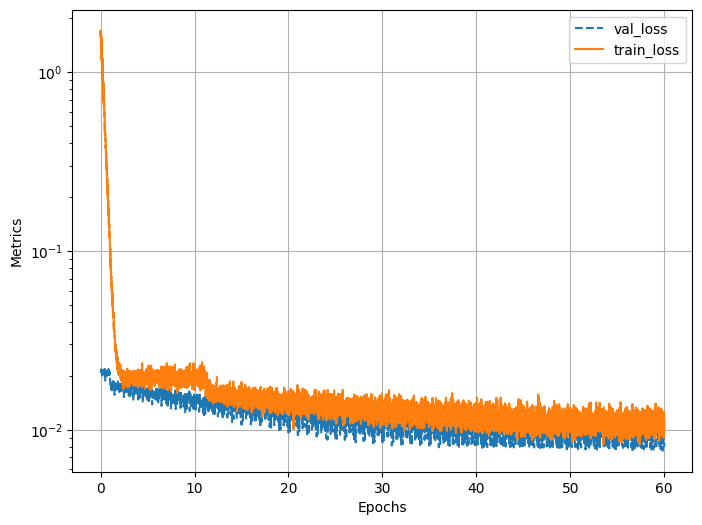

In [19]:
# Train the model
model = load_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_dl, val_dl = load_data()
n_epochs = 60

log = Report(n_epochs)
for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, end='\r')

    if epoch == 10:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
    elif epoch == 40:
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

    if not (epoch+1) % 10:
        log.report_avgs(epoch+1)
log.plot(log=True)

In [20]:
# Make predictions on the zero-shot data
pred_zsl = model(torch.Tensor(x_zsl).to(device)).cpu().detach().numpy()

class_vectors = sorted(np.load(word2vec_path, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)

vectors = np.array(vectors)

In [25]:
# Calculate the distances between the predicted and actual zero-shot class labels
dists = (pred_zsl[None] - vectors[:, None])
dists = (dists**2).sum(-1).T

# Retrieve the top 5 classes with the lowest distances
best_classes = [
    [classnames[j] for j in np.argsort(item)[:5]] for item in dists
]

# Calculate the accuracy of the model
accuracy = np.mean([zero_shot_clss[i] in best_classes[i] for i in range(len(zero_shot_clss))])
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 77.14%